In [5]:
base_dir = '/monfs01/projects/ys68/XRD_SPG_analysis'
data_dir = 'training_data/simXRD_partial_data'
MODEL_SAVE_DIR = 'trained_models'

In [20]:
# Cell 1: Imports and Setup
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from ase.db import connect
import pandas as pd

# Set the working directory to the base of the repo 
os.chdir(base_dir)
from src.data_loading.simXRD_data_loader import create_inference_data_loader

%matplotlib inline
plt.style.use('seaborn-v0_8')

=== Sample Data Overview ===


,Chemical Formula,Number of Elements,Space Group,Crystal System,Bravais Lattice,Mass
0,NV,2,221,Cubic,P,64.9485
1,NV,2,221,Cubic,P,64.9485
2,EuS,2,221,Cubic,P,184.0240
3,EuS,2,221,Cubic,P,184.0240
4,HfPd,2,221,Cubic,P,284.9100


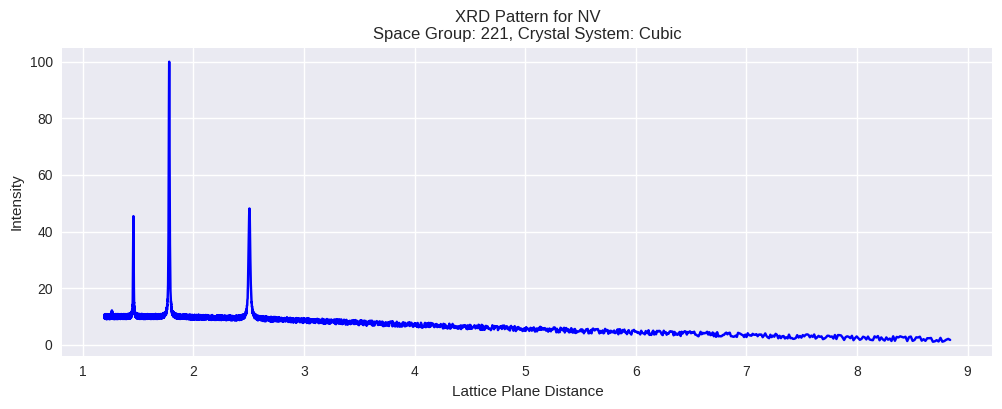

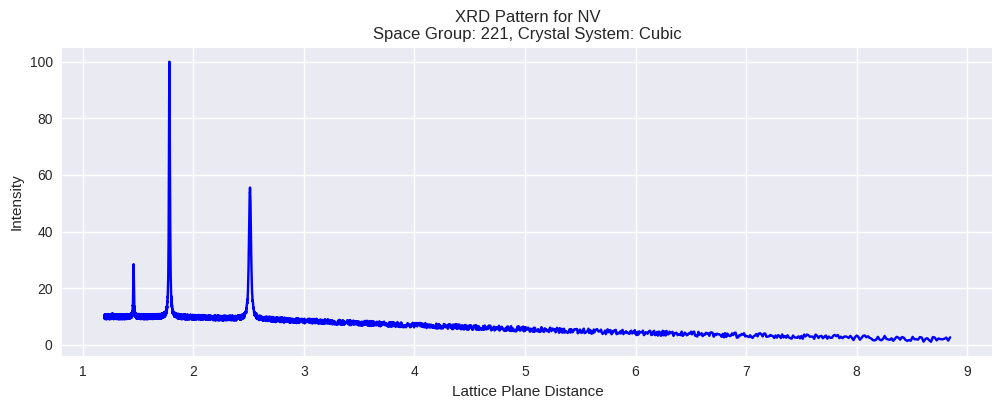

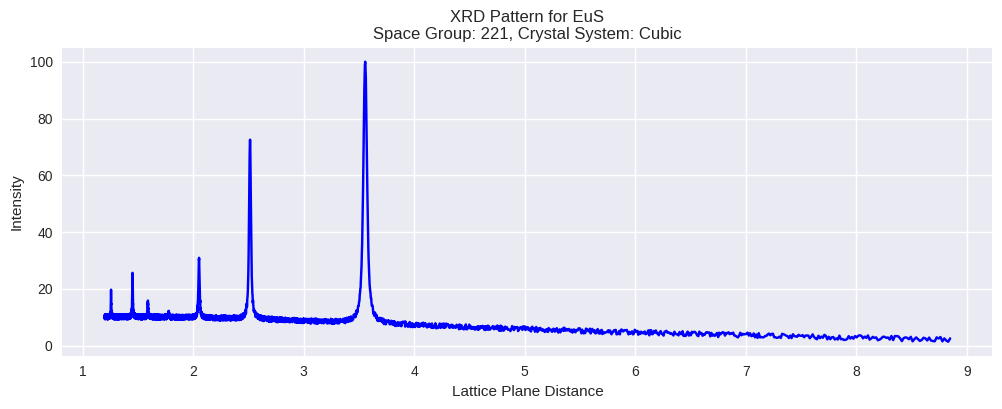

=== Dataset Statistics ===


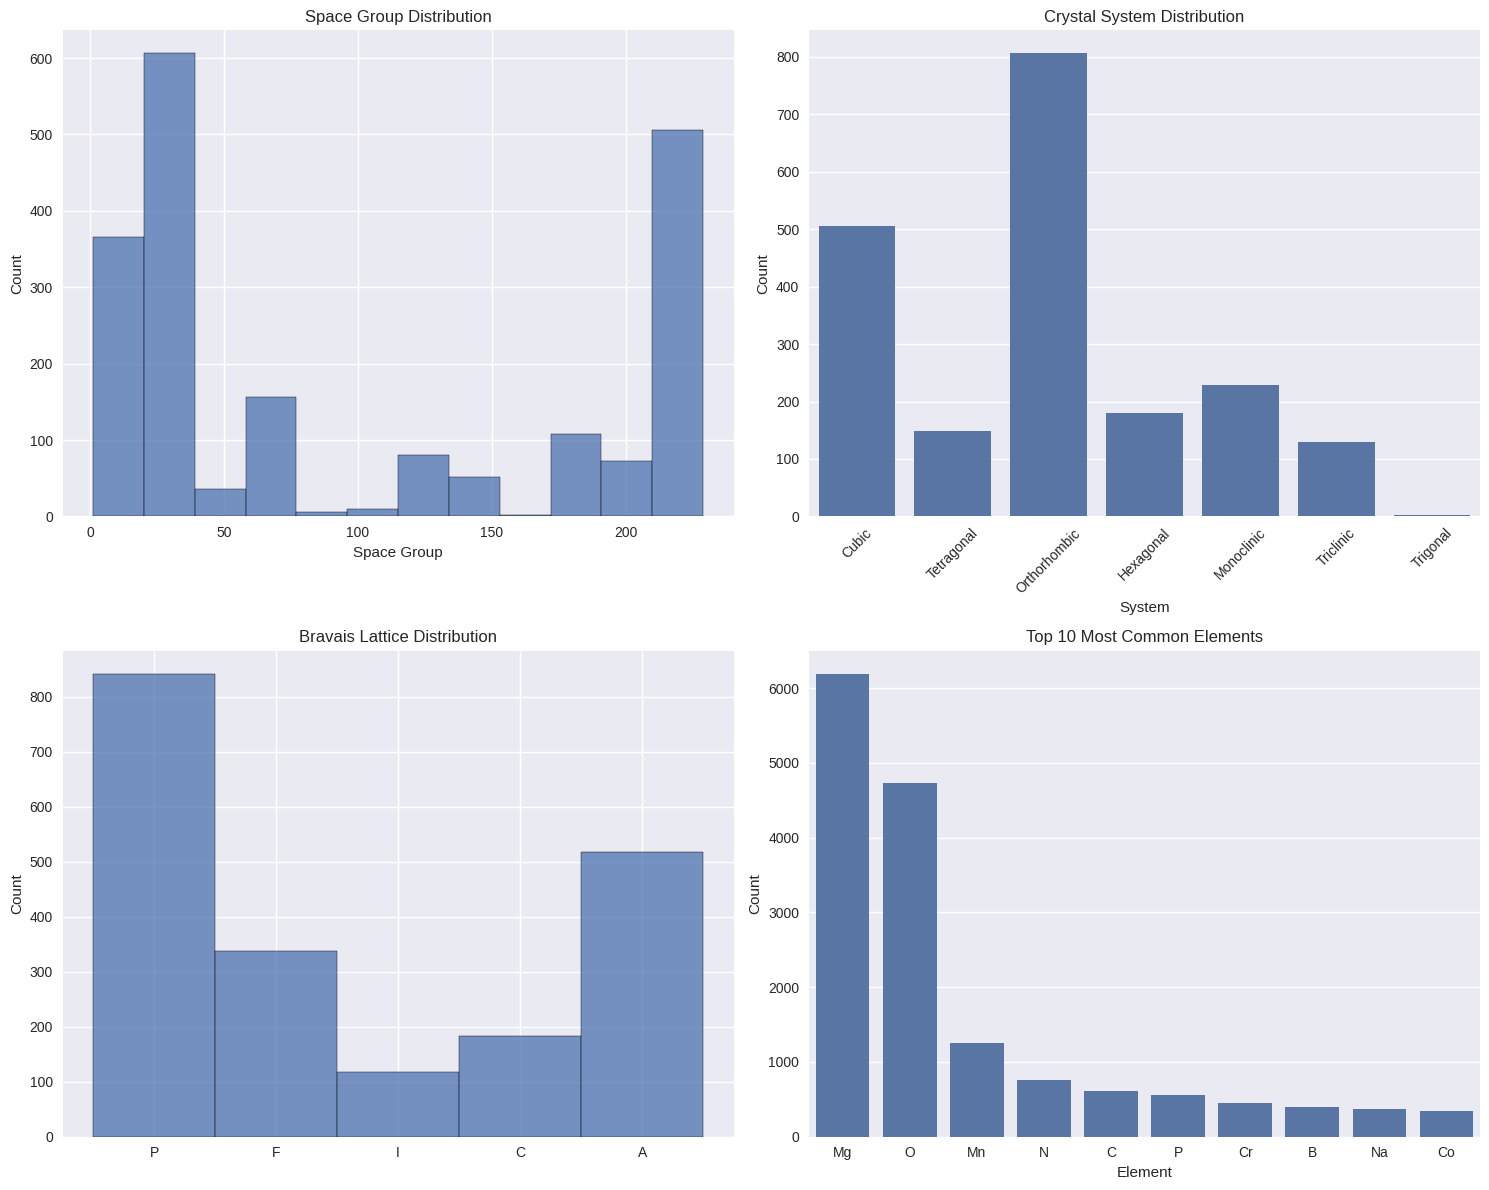

In [21]:
# Cell: Data Inspection Helper Functions
def get_crystal_system_name(system_id):
    """Convert crystal system ID to name."""
    crystal_systems = {
        1: "Cubic",
        2: "Hexagonal",
        3: "Tetragonal",
        4: "Orthorhombic",
        5: "Trigonal",
        6: "Monoclinic",
        7: "Triclinic"
    }
    return crystal_systems.get(system_id, "Unknown")

def plot_sample_xrd(intensity, lattice_dist, title="Sample XRD Pattern"):
    """Plot a single XRD pattern."""
    plt.figure(figsize=(12, 4))
    plt.plot(lattice_dist, intensity, 'b-')
    plt.xlabel('Lattice Plane Distance')
    plt.ylabel('Intensity')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Cell: Load and Display Sample Data
# Load a few samples from the test dataset
db = connect(test_data)
samples = []

for i in range(5):  # Get 5 samples
    row = db.get(i + 1)
    sample = {
        'chemical_formula': row.chem_form,
        'elements': row.symbols,
        'intensity': eval(row.intensity),
        'lattice_dist': eval(row.latt_dis),
        'space_group': eval(row.tager)[0],
        'crystal_system': eval(row.tager)[1],
        'bravais_lattice': eval(row.tager)[2],
        'mass': row.mass
    }
    samples.append(sample)

# Display sample information in a nice format
sample_df = pd.DataFrame([{
    'Chemical Formula': s['chemical_formula'],
    'Number of Elements': len(set(s['elements'])),
    'Space Group': s['space_group'],
    'Crystal System': get_crystal_system_name(s['crystal_system']),
    'Bravais Lattice': s['bravais_lattice'],
    'Mass': s['mass']
} for s in samples])

print("=== Sample Data Overview ===")
display(sample_df)

# Cell: Visualize Sample XRD Patterns
for i, sample in enumerate(samples[:3]):  # Show first 3 samples
    plot_sample_xrd(
        sample['intensity'], 
        sample['lattice_dist'],
        f"XRD Pattern for {sample['chemical_formula']}\n"
        f"Space Group: {sample['space_group']}, "
        f"Crystal System: {get_crystal_system_name(sample['crystal_system'])}"
    )

# Cell: Dataset Statistics
print("=== Dataset Statistics ===")
stats = {
    'space_groups': [],
    'crystal_systems': [],
    'bravais_lattices': [],
    'elements': []
}

for row in db.select():
    tager = eval(row.tager)
    stats['space_groups'].append(tager[0])
    stats['crystal_systems'].append(tager[1])
    stats['bravais_lattices'].append(tager[2])
    stats['elements'].extend(row.symbols)

# Create distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Space Groups
sns.histplot(stats['space_groups'], ax=axes[0,0])
axes[0,0].set_title('Space Group Distribution')
axes[0,0].set_xlabel('Space Group')

# Crystal Systems
crystal_counts = Counter(stats['crystal_systems'])
crystal_df = pd.DataFrame([
    {'System': get_crystal_system_name(k), 'Count': v} 
    for k, v in crystal_counts.items()
])
sns.barplot(data=crystal_df, x='System', y='Count', ax=axes[0,1])
axes[0,1].set_title('Crystal System Distribution')
axes[0,1].tick_labels = plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45)

# Bravais Lattices
sns.histplot(stats['bravais_lattices'], ax=axes[1,0])
axes[1,0].set_title('Bravais Lattice Distribution')

# Elements
element_counts = Counter(stats['elements']).most_common(10)
element_df = pd.DataFrame(element_counts, columns=['Element', 'Count'])
sns.barplot(data=element_df, x='Element', y='Count', ax=axes[1,1])
axes[1,1].set_title('Top 10 Most Common Elements')

plt.tight_layout()
plt.show()

In [ ]:
# Import your custom modules
from src.models.CNNten import CNNten, CNNten_MultiTask, smallCNNten_MultiTask
from src.models.CNNeleven import CNNeleven, CNNeleven_MultiTask
from src.models.smallFCN import smallFCN, smallFCN_MultiTask, smallFCN_SelfAttention_MultiTask, experimentalFCN
from src.models.ViT import ViT1D_MultiTask
from src.models.MLPten import MLPten

# Model configuration
MODEL_NAME = "smallFCN_multi_task_spg_acc_94.6500_20240728_235958.pth"
MODEL_TYPE = "smallFCN_MultiTask"
MULTI_TASK = True
BATCH_SIZE = 32
NUM_WORKERS = 6

# Tasks to evaluate
TASKS = ['spg', 'crysystem', 'blt', 'composition'] if MULTI_TASK else ['spg']

# Model class mapping
MODEL_CLASS = {
    "CNNten": CNNten,
    "CNNten_MultiTask": CNNten_MultiTask,
    "CNNeleven_MultiTask": CNNeleven_MultiTask,
    "smallCNNten_MultiTask": smallCNNten_MultiTask,
    "smallFCN": smallFCN,
    "smallFCN_MultiTask": smallFCN_MultiTask,
    "smallFCN_SelfAttention_MultiTask": smallFCN_SelfAttention_MultiTask,
    "experimentalFCN": experimentalFCN,
    "MLPten": MLPten,
    "ViT1D_MultiTask": ViT1D_MultiTask
}

In [ ]:
# Cell 3: Model Loading
%%capture

# Load model
model_path = os.path.join(MODEL_SAVE_DIR, MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_class = MODEL_CLASS[MODEL_TYPE]
model = model_class()
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

Using device: cpu


/tmp/ipykernel_1675929/1037007327.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


smallFCN_MultiTask(
  (conv1): Conv1d(1, 16, kernel_size=(6,), stride=(1,), padding=(2,))
  (conv2): Conv1d(16, 16, kernel_size=(6,), stride=(1,), padding=(2,))
  (conv3): Conv1d(16, 32, kernel_size=(6,), stride=(1,), padding=(2,))
  (conv4): Conv1d(32, 32, kernel_size=(6,), stride=(1,), padding=(2,))
  (conv5): Conv1d(32, 64, kernel_size=(6,), stride=(1,), padding=(2,))
  (conv6): Conv1d(64, 64, kernel_size=(6,), stride=(1,), padding=(2,))
  (conv7): Conv1d(64, 128, kernel_size=(6,), stride=(1,), padding=(2,))
  (conv8): Conv1d(128, 128, kernel_size=(6,), stride=(1,), padding=(2,))
  (conv9): Conv1d(128, 256, kernel_size=(6,), stride=(1,), padding=(2,))
  (conv10): Conv1d(256, 256, kernel_size=(6,), stride=(1,), padding=(2,))
  (crysystem_conv_1): Conv1d(256, 64, kernel_size=(6,), stride=(1,), padding=(2,))
  (crysystem_conv_2): Conv1d(64, 7, kernel_size=(1,), stride=(1,))
  (blt_conv_1): Conv1d(256, 64, kernel_size=(6,), stride=(1,), padding=(2,))
  (blt_conv_2): Conv1d(64, 6, kernel

In [12]:
# Cell 4: Data Loading
test_data = os.path.join(data_dir, 'test.db')
test_loader = create_inference_data_loader(test_data, BATCH_SIZE, NUM_WORKERS)

In [14]:
# Cell 5: Run Inference and Store Data
all_predictions = {task: [] for task in TASKS}
all_labels = {task: [] for task in TASKS}

with torch.no_grad():
    for batch in test_loader:
        intensity, spg, crysystem, blt, composition = [t.to(device) for t in batch]
        
        if MULTI_TASK:
            outputs = model(intensity.unsqueeze(1))
            
            # Handle predictions for each task
            for task in TASKS:
                if task == 'composition':
                    preds = torch.sigmoid(outputs[task])
                    all_predictions[task].extend(preds.cpu().numpy())
                else:
                    preds = outputs[task].argmax(dim=1)
                    all_predictions[task].extend(preds.cpu().numpy())
            
            # Store labels
            all_labels['spg'].extend(spg.cpu().numpy())
            all_labels['crysystem'].extend(crysystem.cpu().numpy())
            all_labels['blt'].extend(blt.cpu().numpy())
            all_labels['composition'].extend(composition.cpu().numpy())
        else:
            output = model(intensity.unsqueeze(1))
            preds = output.argmax(dim=1)
            all_predictions['spg'].extend(preds.cpu().numpy())
            all_labels['spg'].extend(spg.cpu().numpy())

# Convert lists to numpy arrays for easier analysis
for task in TASKS:
    all_predictions[task] = np.array(all_predictions[task])
    all_labels[task] = np.array(all_labels[task])

print("Inference completed! Data stored in all_predictions and all_labels")

Inference completed! Data stored in all_predictions and all_labels


In [15]:
# Cell 6: Basic Accuracy Analysis
# Calculate and display basic accuracy metrics
print("=== Basic Accuracy Metrics ===")
for task in TASKS:
    if task != 'composition':
        accuracy = (all_predictions[task] == all_labels[task]).mean()
        print(f"{task} Accuracy: {accuracy:.4f}")
        
        # Calculate per-class accuracy
        unique_classes = np.unique(all_labels[task])
        print(f"\nPer-class accuracy for {task}:")
        for clss in unique_classes:
            mask = all_labels[task] == clss
            class_acc = (all_predictions[task][mask] == all_labels[task][mask]).mean()
            print(f"Class {clss}: {class_acc:.4f}")
    else:
        # For composition, calculate binary cross-entropy
        bce = -np.mean(all_labels[task] * np.log(all_predictions[task] + 1e-10) + 
                      (1 - all_labels[task]) * np.log(1 - all_predictions[task] + 1e-10))
        print(f"\nComposition BCE Loss: {bce:.4f}")

=== Basic Accuracy Metrics ===
spg Accuracy: 0.9465

Per-class accuracy for spg:
Class 0: 0.9545
Class 1: 0.9762
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Class 5: 0.8636
Class 6: 0.9000
Class 7: 1.0000
Class 8: 1.0000
Class 9: 1.0000
Class 10: 0.9355
Class 11: 0.9792
Class 12: 1.0000
Class 13: 0.9167
Class 14: 1.0000
Class 18: 1.0000
Class 19: 1.0000
Class 20: 1.0000
Class 23: 1.0000
Class 24: 1.0000
Class 25: 0.5000
Class 27: 1.0000
Class 28: 1.0000
Class 32: 1.0000
Class 35: 1.0000
Class 36: 1.0000
Class 37: 0.9942
Class 39: 1.0000
Class 43: 1.0000
Class 45: 1.0000
Class 46: 1.0000
Class 50: 1.0000
Class 52: 1.0000
Class 56: 1.0000
Class 57: 1.0000
Class 59: 0.7500
Class 60: 1.0000
Class 61: 0.9583
Class 62: 0.9231
Class 63: 1.0000
Class 64: 0.9286
Class 68: 0.5000
Class 70: 1.0000
Class 71: 1.0000
Class 73: 0.7500
Class 76: 1.0000
Class 84: 1.0000
Class 85: 1.0000
Class 95: 0.5000
Class 98: 1.0000
Class 106: 0.6667
Class 114: 1.0000
Class 118: 0.7500
Class 120: 1.0000
Class 1

In [16]:
# Cell 7: Task Correlation Analysis
if MULTI_TASK:
    print("\n=== Task Correlation Analysis ===")
    for task1 in TASKS:
        if task1 != 'composition':
            correct_task1 = all_predictions[task1] == all_labels[task1]
            for task2 in TASKS:
                if task2 != 'composition' and task2 != task1:
                    correct_task2 = all_predictions[task2] == all_labels[task2]
                    correlation = np.mean(correct_task1 == correct_task2)
                    print(f"Correlation between {task1} and {task2} correctness: {correlation:.4f}")



=== Task Correlation Analysis ===
Correlation between spg and crysystem correctness: 0.9515
Correlation between spg and blt correctness: 0.9540
Correlation between crysystem and spg correctness: 0.9515
Correlation between crysystem and blt correctness: 0.9695
Correlation between blt and spg correctness: 0.9540
Correlation between blt and crysystem correctness: 0.9695


In [17]:
# Cell 8: Confusion Matrix Function
def plot_confusion_matrix(task):
    if task == 'composition':
        print("Confusion matrix not applicable for composition task")
        return
        
    unique_classes = np.unique(all_labels[task])
    cm = np.zeros((len(unique_classes), len(unique_classes)))
    
    for i in range(len(all_predictions[task])):
        cm[all_labels[task][i], all_predictions[task][i]] += 1
    
    # Normalize
    cm = cm / cm.sum(axis=1, keepdims=True)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'Confusion Matrix for {task}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [18]:
# Optional Cell 9: Plot all confusion matrices
for task in TASKS:
    if task != 'composition':
        plot_confusion_matrix(task)

IndexError: index 220 is out of bounds for axis 0 with size 76